Notebook created: 2018-07-22 01:43:10  
Generated from: _build_jl/jl/mccall_model_with_separation.rst  

In [1]:
using Distributions

# A default utility function

function u(c::Real, σ::Real)
    if c > 0
        return (c^(1 - σ) - 1) / (1 - σ)
    else
        return -10e6
    end
end

# default wage vector with probabilities

const n = 60                                   # n possible outcomes for wage
const default_w_vec = linspace(10, 20, n)      # wages between 10 and 20
const a, b = 600, 400                          # shape parameters
const dist = BetaBinomial(n-1, a, b)
const default_p_vec = pdf.(dist, support(dist))

mutable struct McCallModel{TF <: AbstractFloat,
                           TAV <: AbstractVector{TF},
                           TAV2 <: AbstractVector{TF}}
    α::TF         # Job separation rate
    β::TF         # Discount rate
    γ::TF         # Job offer rate
    c::TF         # Unemployment compensation
    σ::TF         # Utility parameter
    w_vec::TAV    # Possible wage values
    p_vec::TAV2   # Probabilities over w_vec

    McCallModel(α::TF=0.2,
                β::TF=0.98,
                γ::TF=0.7,
                c::TF=6.0,
                σ::TF=2.0,
                w_vec::TAV=default_w_vec,
                p_vec::TAV2=default_p_vec) where {TF, TAV, TAV2} =
        new{TF, TAV, TAV2}(α, β, γ, c, σ, w_vec, p_vec)
end

"""
A function to update the Bellman equations.  Note that V_new is modified in
place (i.e, modified by this function).  The new value of U is returned.

"""
function update_bellman!(mcm::McCallModel,
                         V::AbstractVector,
                         V_new::AbstractVector,
                         U::Real)
    # Simplify notation
    α, β, σ, c, γ = mcm.α, mcm.β, mcm.σ, mcm.c, mcm.γ

    for (w_idx, w) in enumerate(mcm.w_vec)
        # w_idx indexes the vector of possible wages
        V_new[w_idx] = u(w, σ) + β * ((1 - α) * V[w_idx] + α * U)
    end

    U_new = u(c, σ) + β * (1 - γ) * U +
                    β * γ * dot(max.(U, V), mcm.p_vec)

    return U_new
end


function solve_mccall_model(mcm::McCallModel;
                            tol::AbstractFloat=1e-5,
                            max_iter::Integer=2000)

    V = ones(length(mcm.w_vec))    # Initial guess of V
    V_new = similar(V)             # To store updates to V
    U = 1.0                        # Initial guess of U
    i = 0
    error = tol + 1

    while error > tol && i < max_iter
        U_new = update_bellman!(mcm, V, V_new, U)
        error_1 = maximum(abs, V_new - V)
        error_2 = abs(U_new - U)
        error = max(error_1, error_2)
        V[:] = V_new
        U = U_new
        i += 1
    end

    return V, U
end

solve_mccall_model (generic function with 1 method)

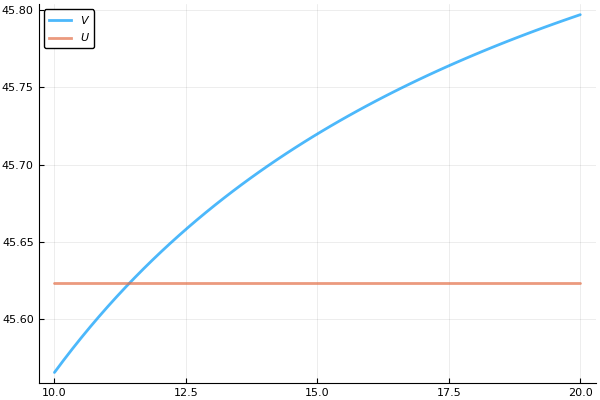

In [2]:
using Plots, LaTeXStrings
pyplot()


mcm = McCallModel()
V, U = solve_mccall_model(mcm)
U_vec = U .* ones(length(mcm.w_vec))

plot(mcm.w_vec, 
     [V U_vec],
     lw=2, 
     α=0.7, 
     label=[L"$V$" L"$U$"])

In [ ]:
"""
Computes the reservation wage of an instance of the McCall model
by finding the smallest w such that V(w) > U.

If V(w) > U for all w, then the reservation wage w_bar is set to
the lowest wage in mcm.w_vec.

If v(w) < U for all w, then w_bar is set to np.inf.

Parameters
----------
mcm : an instance of McCallModel
return_values : bool (optional, default=false)
    Return the value functions as well

Returns
-------
w_bar : scalar
    The reservation wage

"""
function compute_reservation_wage(mcm::McCallModel; return_values::Bool=false)

    V, U = solve_mccall_model(mcm)
    w_idx = searchsortedfirst(V - U, 0)

    if w_idx == length(V)
        w_bar = Inf
    else
        w_bar = mcm.w_vec[w_idx]
    end

    if return_values == false
        return w_bar
    else
        return w_bar, V, U
    end

end

In [ ]:
grid_size = 25
γ_vals = linspace(0.05, 0.95, grid_size)

In [ ]:
grid_size = 25  
c_vals = linspace(2, 12, grid_size)  
w_bar_vals = similar(c_vals)

mcm = McCallModel()

for (i, c) in enumerate(c_vals)
    mcm.c = c
    w_bar = compute_reservation_wage(mcm)
    w_bar_vals[i] = w_bar
end

plot(c_vals, 
     w_bar_vals, 
     lw=2, 
     α=0.7, 
     xlabel="unemployment compensation",
     ylabel="reservation wage",
     label=L"$\bar w$ as a function of $c$")

In [ ]:
grid_size = 25  
γ_vals = linspace(0.05, 0.95, grid_size)  
w_bar_vals = similar(γ_vals)

mcm = McCallModel()

for (i, γ) in enumerate(γ_vals)
    mcm.γ = γ
    w_bar = compute_reservation_wage(mcm)
    w_bar_vals[i] = w_bar
end

plot(γ_vals, 
     w_bar_vals, 
     lw=2, 
     α=0.7, 
     xlabel="job offer rate",
     ylabel="reservation wage",
     label=L"$\bar w$ as a function of $γ$")